## LSTM Bot QA

El objetivo de este notebook es utilizar los datos del challenge ConvAI2 (Conversational Intelligence Challenge 2) con conversaciones en inglés para desarrollar un chatbot basado en una arquitectura Encoder-Decoder capaz de responder preguntas de usuario.

### Librerías

In [16]:
#!pip install gdown

import os
import json
import re
import gdown

import logging
from pathlib import Path
from io import StringIO
import pickle

import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

### Carga de datos

In [2]:
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print('El dataset ya se encuentra descargado')

text_file = 'data_volunteers.json'
with open(text_file) as f:
    data = json.load(f)

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 41.2MB/s]


In [3]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [4]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace('\'d', ' had')
    txt.replace('\'s', ' is')
    txt.replace('\'m', ' am')
    txt.replace('don\'t', 'do not')
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog']) - 1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i + 1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print('Cantidad de rows utilizadas:', len(input_sentences))

Cantidad de rows utilizadas: 6033


In [5]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### Preprocesamiento

In [6]:
MAX_VOCAB_SIZE = 8000

input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
word2idx_inputs = input_tokenizer.word_index
print('Palabras en el vocabulario:', len(word2idx_inputs))
max_input_len = max(len(sen) for sen in input_integer_seq)
print('Sentencia de entrada más larga:', max_input_len)

output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(['<sos>', '<eos>'] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
word2idx_outputs = output_tokenizer.word_index
num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
print('Palabras en el vocabulario de salida:', num_words_output)
max_out_len = max(len(sen) for sen in output_integer_seq)
print('Sentencia de salida más larga:', max_out_len)

print('\nPalabras a índices de entrada:')
print(list(word2idx_inputs.items())[:5])
print('\nPalabras a índices de salida:')
print(list(word2idx_outputs.items())[:5])

Palabras en el vocabulario: 1799
Sentencia de entrada más larga: 9
Palabras en el vocabulario de salida: 1807
Sentencia de salida más larga: 10

Palabras a índices de entrada:
[('i', 1), ('you', 2), ('do', 3), ('what', 4), ('a', 5)]

Palabras a índices de salida:
[('<eos>', 1), ('you', 2), ('i', 3), ('do', 4), ('what', 5)]


In [7]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print('encoder_input_sequences shape:', encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print('decoder_input_sequences shape:', decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
print('decoder_targets shape:', decoder_targets.shape)

encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)
decoder_targets shape: (6033, 10, 1807)


### Embeddings

In [8]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [9]:
!gdown 1BnZU5QLFZviKVGKYEnHrVuBAJDw6imXx

model_embeddings = FasttextEmbeddings()

# Crear la Embedding matrix de las secuencias en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))
print('embedding_matrix shape', embedding_matrix.shape)

Downloading...
From (original): https://drive.google.com/uc?id=1BnZU5QLFZviKVGKYEnHrVuBAJDw6imXx
From (redirected): https://drive.google.com/uc?id=1BnZU5QLFZviKVGKYEnHrVuBAJDw6imXx&confirm=t&uuid=70200537-2219-4753-8c9a-71af26089423
To: /content/cc.en.300.vec
100% 4.51G/4.51G [00:45<00:00, 98.5MB/s]
preparing embedding matrix...
number of null word embeddings: 1
embedding_matrix shape (1799, 300)


### Modelo

In [24]:
n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, dropout=0.2, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, dropout=0.2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 9, 300)               539700    ['input_6[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 10, 128)              231296    ['input_7[0][0]']             
                                                                                            

In [25]:
# Inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

# Inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

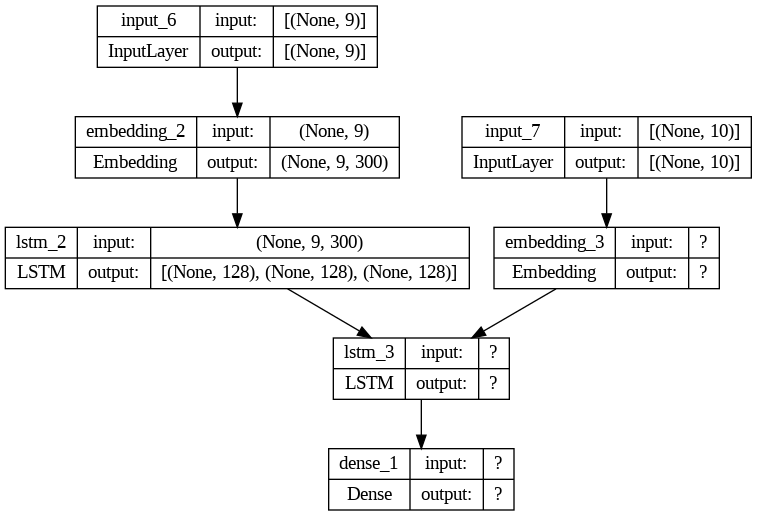

In [26]:
# Modelo completo (encoder + decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

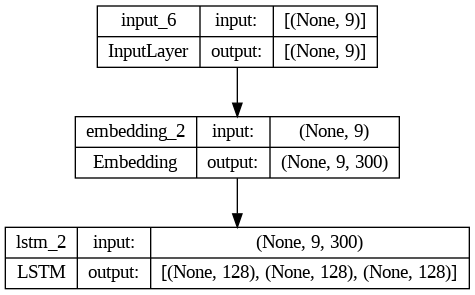

In [27]:
# Modelo encoder
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

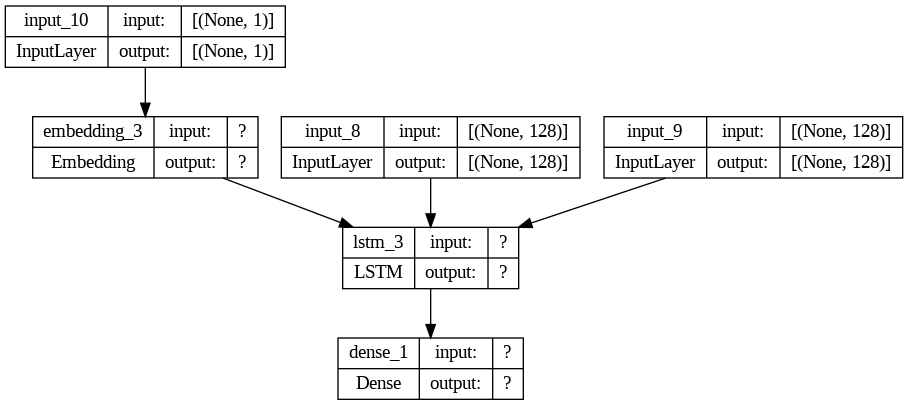

In [28]:
# Modelo decoder
plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

### Entrenamiento

In [29]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2)

Epoch 1/50
151/151 [==============================] - 10s 35ms/step - loss: 3.0873 - accuracy: 0.5071 - val_loss: 2.3097 - val_accuracy: 0.6255
Epoch 2/50
151/151 [==============================] - 2s 13ms/step - loss: 2.1041 - accuracy: 0.6179 - val_loss: 2.1159 - val_accuracy: 0.6476
Epoch 3/50
151/151 [==============================] - 2s 10ms/step - loss: 1.8492 - accuracy: 0.6755 - val_loss: 1.9398 - val_accuracy: 0.6896
Epoch 4/50
151/151 [==============================] - 2s 15ms/step - loss: 1.6670 - accuracy: 0.7094 - val_loss: 1.8457 - val_accuracy: 0.6989
Epoch 5/50
151/151 [==============================] - 2s 16ms/step - loss: 1.5559 - accuracy: 0.7215 - val_loss: 1.7925 - val_accuracy: 0.7039
Epoch 6/50
151/151 [==============================] - 3s 17ms/step - loss: 1.4778 - accuracy: 0.7314 - val_loss: 1.7487 - val_accuracy: 0.7104
Epoch 7/50
151/151 [==============================] - 3s 17ms/step - loss: 1.4197 - accuracy: 0.7375 - val_loss: 1.7199 - val_accuracy: 0.713

### Gráfica de entrenamiento

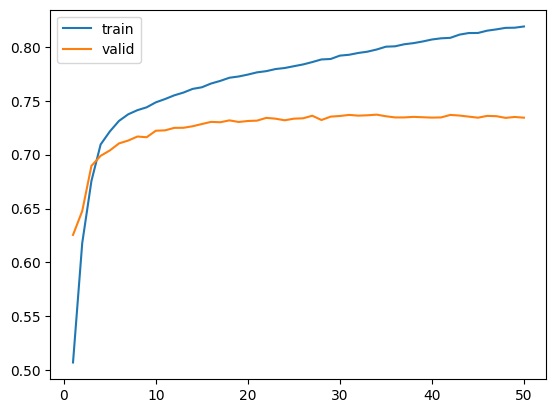

In [30]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### Inferencia

In [31]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [32]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 [==============================] - 0s 23ms/step
-
Input: what
Response: i love to read


In [33]:
input_test = 'My mother say hi.'
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print('Representación en vector de tokens de ids', integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print('Padding del vector:', encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My mother say hi.
Representación en vector de tokens de ids [36, 356, 113, 11]
Padding del vector: [[  0   0   0   0   0  36 356 113  11]]
Input: My mother say hi.
1/1 [==============================] - 0s 18ms/step
Response: what do you do for a living


In [34]:
input_test = 'Do you read?'
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print('Representación en vector de tokens de ids', integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print('Padding del vector:', encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: Do you read?
Representación en vector de tokens de ids [3, 2, 23]
Padding del vector: [[ 0  0  0  0  0  0  3  2 23]]
Input: Do you read?
1/1 [==============================] - 0s 19ms/step
Response: i like to play video games


In [35]:
input_test = 'Do you have any pet?'
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print('Representación en vector de tokens de ids', integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print('Padding del vector:', encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: Do you have any pet?
Representación en vector de tokens de ids [3, 2, 16, 31, 252]
Padding del vector: [[  0   0   0   0   3   2  16  31 252]]
Input: Do you have any pet?
1/1 [==============================] - 0s 24ms/step
Response: no


In [36]:
input_test = 'Where are you from?'
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print('Representación en vector de tokens de ids', integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print('Padding del vector:', encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: Where are you from?
Representación en vector de tokens de ids [52, 7, 2, 39]
Padding del vector: [[ 0  0  0  0  0 52  7  2 39]]
Input: Where are you from?
1/1 [==============================] - 0s 19ms/step
Response: i am a teacher
